<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_2021_aug_tabular_playground_series_aug_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew

In [2]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
train.shape, test.shape, submit.shape

((250000, 102), (150000, 101), (150000, 2))

In [12]:
train['loss'].skew()  # target 라벨에 log1p씌울까 

1.4653191365369271

Text(0.5, 1.0, 'Train set Skew')

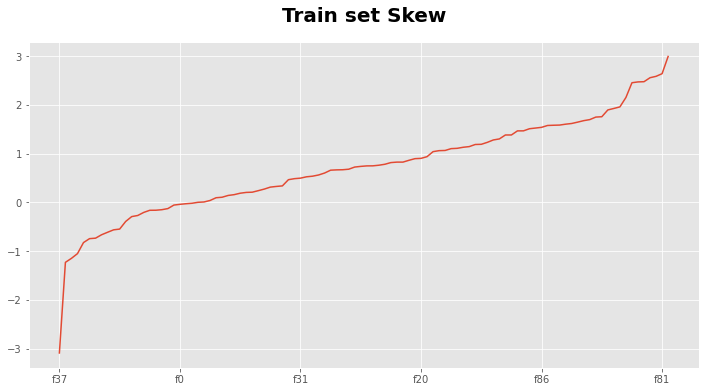

In [33]:
plt.figure(figsize=(12,6))
train.skew().sort_values().plot()
plt.title('Train set Skew', fontsize=20, fontweight='bold', pad=20)
# noramlize를 적용 할까 고민

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.concat([train.drop(columns=['id']), test.drop(columns=['id'])], axis=0)
data_columns = data.columns

for i in data.columns:
  if i == 'loss':
    continue
  data[i] = MinMaxScaler().fit_transform(data[[i]])

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
0,0.058629,0.262069,0.487568,0.044327,0.169648,0.520648,0.072185,0.649785,0.519117,0.206179,0.642215,0.924067,0.139886,0.241492,0.522506,0.458274,0.149490,0.861167,0.634045,0.515816,0.128709,0.295453,0.220101,0.118041,0.528319,0.293981,0.218395,0.149176,0.280389,0.242349,0.241053,0.820178,0.440549,0.192237,0.912760,0.022386,0.251121,0.772979,0.541373,0.310286,...,0.415399,0.099083,0.142643,0.298365,0.536726,0.309271,0.653382,0.382454,0.499299,0.365601,0.430743,0.084651,0.544248,0.119033,0.304466,0.390744,0.461410,0.377160,0.247282,0.460085,0.358525,0.791858,0.293070,0.507918,0.308818,0.368788,0.294811,0.352668,0.297774,0.216865,0.188535,0.367411,0.260967,0.684652,0.379244,0.440822,0.835195,0.574901,0.325062,15.0
1,0.747917,0.558621,0.418759,0.302915,0.759722,0.176353,0.203889,0.597026,0.522567,0.449356,0.394979,0.329002,0.753923,0.080106,0.547212,0.327181,0.714358,0.304544,0.344847,0.320003,0.143570,0.146598,0.190955,0.297211,0.257788,0.425950,0.827305,0.952506,0.366381,0.063083,0.363304,0.575442,0.513549,0.204553,0.322209,0.040393,0.314166,0.643070,0.559805,0.669755,...,0.437045,0.179187,0.639739,0.351203,0.681399,0.414703,0.299537,0.262655,0.510463,0.258802,0.317454,0.447597,0.643608,0.515874,0.259031,0.772076,0.434954,0.322874,0.063164,0.503037,0.332094,0.602050,0.209909,0.580289,0.879815,0.108108,0.284587,0.319350,0.156863,0.158080,0.186424,0.142704,0.307378,0.383749,0.334849,0.290536,0.394403,0.588088,0.056975,3.0
2,0.339111,0.124138,0.420507,0.349514,0.198651,0.599544,0.072937,0.435689,0.554232,0.399180,0.691212,0.222364,0.159713,0.267771,0.549790,0.363919,0.040679,0.477373,0.507251,0.533169,0.048060,0.410980,0.197945,0.130027,0.306345,0.609937,0.679043,0.183457,0.134451,0.298190,0.245849,0.444690,0.713871,0.178544,0.214957,0.210273,0.342165,0.722923,0.524900,0.630095,...,0.549986,0.334125,0.536857,0.370641,0.071842,0.395572,0.600923,0.387391,0.503596,0.293274,0.364488,0.487405,0.657048,0.223446,0.644120,0.353096,0.428799,0.260026,0.274752,0.278299,0.375627,0.693164,0.134951,0.348827,0.560573,0.114211,0.214656,0.361987,0.118492,0.206417,0.189278,0.490290,0.595796,0.594136,0.374409,0.498640,0.672652,0.458797,0.377146,6.0
3,0.245318,0.117241,0.410225,0.768598,0.166155,0.192171,0.228946,0.663718,0.469688,0.206550,0.459435,0.140188,0.264186,0.258302,0.301345,0.416480,0.066962,0.800010,0.538116,0.472968,0.057247,0.194933,0.280057,0.264421,0.263885,0.271801,0.438998,0.841225,0.833556,0.164926,0.258894,0.252221,0.661158,0.100820,0.220030,0.246658,0.376997,0.722502,0.299366,0.735707,...,0.367430,0.197600,0.502436,0.363149,0.511708,0.478107,0.653945,0.391497,0.509111,0.612842,0.425534,0.402770,0.620496,0.405423,0.237222,0.193855,0.456118,0.359251,0.180971,0.557912,0.394139,0.823947,0.238525,0.478585,0.643391,0.469050,0.407926,0.336033,0.165232,0.206547,0.189311,0.056456,0.267817,0.639511,0.214041,0.559772,0.556307,0.412273,0.311839,2.0
4,0.445862,0.127586,0.498829,0.440993,0.170341,0.406514,0.114515,0.469484,0.543883,0.219592,0.631962,0.324726,0.594514,0.527764,0.521368,0.456900,0.590345,0.555367,0.532751,0.433929,0.024313,0.293987,0.196035,0.057138,0.412392,0.390207,0.824837,0.095792,0.061593,0.344803,0.713066,0.414485,0.218338,0.296857,0.314125,0.030242,0.317456,0.698609,0.540605,0.792992,...,0.571206,0.299165,0.518703,0.382479,0.521344,0.339856,0.569831,0.461571,0.396864,0.380581,0.401812,0.360279,0.306988,0.160326,0.205025,0.614190,0.500041,0.333013,0.224002,0.368799,0.326923,0.603639,0.244301,0.088529,0.635399,0.117698,0.214108,0.220921,0.128192,0.255918,0.193498,0.234031,0.312809,0.388305,0.385880,0.495510,0.746932,0.475843,0.227023,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [37]:
from sklearn.cluster import DBSCAN

data['cluster'] = DBSCAN(n_jobs=-1).fit_predict(data.drop(columns=['loss']))
data

KeyboardInterrupt: ignored

In [35]:
data['cluster'].value_counts()

-1    400000
Name: cluster, dtype: int64

# Clustering 적용하자

In [3]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 67.4 MB 41 kB/s 
     |████████████████████████████████| 302 kB 7.7 MB/s 
     |████████████████████████████████| 80 kB 10.7 MB/s 
     |████████████████████████████████| 164 kB 75.0 MB/s 
     |████████████████████████████████| 75 kB 5.7 MB/s 
     |████████████████████████████████| 111 kB 64.4 MB/s 
     |████████████████████████████████| 49 kB 7.7 MB/s 
     |████████████████████████████████| 141 kB 64.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=b91f891de74ff6265f2306ebeaf71d4ce133fd4f74bda1b09b803d7f8ea8682d
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
import catboost
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [10]:
# 데이터 나누기
x_train = train.drop(columns=['id', 'loss'])
y_train = train['loss']
x_test = test.drop(columns=['id'])
x_train_columns = x_train.columns
x_test_columns = x_test.columns
x_train.shape, y_train.shape, x_test.shape

((250000, 100), (250000,), (150000, 100))

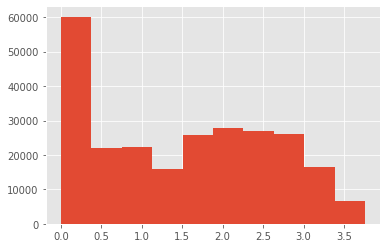

In [49]:
np.log1p(y_train).hist()

In [11]:
mm = MinMaxScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'elbow method')

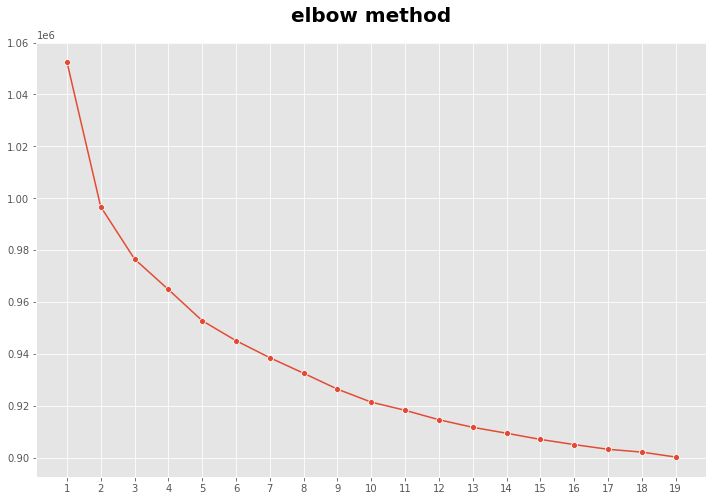

In [20]:
# Clustering
from sklearn.cluster import KMeans

vstack = np.vstack((x_train,
                    x_test))

sse = {}
for i in range(1,20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, random_state=0, n_jobs=-1).fit(vstack)
  sse[i] = km.inertia_

plt.figure(figsize=(12,8))
sns.lineplot(pd.Series(sse).index, pd.Series(sse), marker='o')
plt.xticks(pd.Series(sse).index)
plt.title('elbow method', fontsize=20, fontweight='bold', pad=20)

In [ ]:
km = KMeans(n_splits=, max_iter=1000, n_jobs=-1).fit(vstack)

x_train['cluster'] = km.predict(x_train)
x_test['cluster'] = km.predict(x_test)

# cluster DBSCAN기법

- DBSCAN(density-based spatial clustering of application with noise)은 클러스터의 갯수를 미리 지정하지 않는 군집 알고리즘


- DBSCAN은 병합 군집이나 k-평균보다는 다소 느리지만 비교적 큰 데이터셋에도 적용



- 데이터의 밀집지역이 한 클러스터를 구성하며 비교적 비어있는 지역을 경계로 다른 클러스터와 구분함



- DBSCAN은 특성 공간에서 가까이 있는 데이터가 많아 붐비는 지역의 포인트를 찾음

- 이런 지역을 밀집 지역dense region이라 함

- 밀집 지역에 있는 포인트를 핵심 포인트core point라고함



- 핵심 포인트: min_samples, epsepsilon

  - 한 데이터 포인트에서 eps 거리 안에 데이터가 min_samples 갯수만큼 들어 있으면 이 데이터 포인트를 핵심 포인트로 분류

  - eps(거리)보다 가까운 핵심 샘플은 동일한 클러스터로 분류

In [ ]:
ss = StandardScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

In [40]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(iterations=3000, learning_rate=0.022, loss_function='RMSE', eval_metric='RMSE', task_type='GPU')
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += model_cat.predict(x_test) / sk.n_splits

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



0:	learn: 7.9395958	test: 7.9385808	best: 7.9385808 (0)	total: 184ms	remaining: 9m 12s
100:	learn: 7.9016019	test: 7.9093593	best: 7.9093593 (100)	total: 10.3s	remaining: 4m 56s
200:	learn: 7.8812176	test: 7.8962584	best: 7.8962584 (200)	total: 20.7s	remaining: 4m 48s
300:	learn: 7.8652380	test: 7.8869769	best: 7.8869769 (300)	total: 31s	remaining: 4m 37s
400:	learn: 7.8515070	test: 7.8806182	best: 7.8806182 (400)	total: 41s	remaining: 4m 25s
500:	learn: 7.8382871	test: 7.8754247	best: 7.8754247 (500)	total: 51s	remaining: 4m 14s
600:	learn: 7.8247728	test: 7.8703063	best: 7.8703063 (600)	total: 1m	remaining: 4m 1s
700:	learn: 7.8099331	test: 7.8657610	best: 7.8657610 (700)	total: 1m 9s	remaining: 3m 49s
800:	learn: 7.7948899	test: 7.8619787	best: 7.8619787 (800)	total: 1m 19s	remaining: 3m 37s
900:	learn: 7.7807350	test: 7.8595876	best: 7.8595876 (900)	total: 1m 28s	remaining: 3m 27s
1000:	learn: 7.7668757	test: 7.8570850	best: 7.8570684 (999)	total: 1m 38s	remaining: 3m 16s
1100:	lea

In [ ]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params = {'iterations':study.best_params['iterations'],
         'loss_function':'RMSE',
         'task_type':"GPU",
         'eval_metric':'RMSE',
         'leaf_estimation_method':'Newton',
         'bootstrap_type': 'Bernoulli',
         'learning_rate' : study.best_params['learning_rate'],
         'reg_lambda': study.best_params['reg_lambda'],
         'subsample': study.best_params['subsample'],
         'random_strength': study.best_params['random_strength'],
         'depth': study.best_params['depth'],
         'min_data_in_leaf': study.best_params['min_data_in_leaf'],
         'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
         'grow_policy' : 'Depthwise',  
}

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(**params)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += model_cat.predict(x_test) / sk.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

In [50]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
submit['loss'] = preds
submit

,id,loss
0,250000,8.070131
1,250001,4.530393
2,250002,8.184680
3,250003,7.285231
4,250004,7.296131
...,...,...
149995,399995,7.308085
149996,399996,7.051310
149997,399997,6.020954
149998,399998,5.603730


In [52]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/submit1.csv', index=False)